使用现有模型进行推理 — MMPose 1.2.0 文档

[使用现有模型进行推理 — MMPose 1.2.0 文档](https://mmpose.readthedocs.io/zh-cn/latest/user_guides/inference.html#api)

# 人脸关键点检测预测-Python API

## 进入 mmpose 主目录

In [1]:
import os
os.chdir('mmpose')

In [2]:
!pwd

/e/openmmlab/MMPose_Tutorials/2023/0524/mmpose


## 导入工具包

In [3]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [4]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [5]:
img_path = 'tests/data/cofw/001766.jpg'

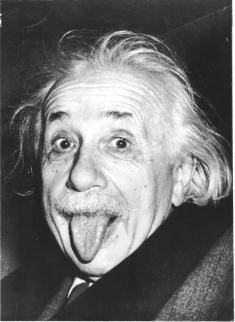

In [6]:
Image.open(img_path)

## 准备好的模型文件

In [7]:
# 人脸目标检测
# 配置文件
# demo/mmdetection_cfg/yolox-s_8xb8-300e_coco-face.py 
# 模型文件
# https://download.openmmlab.com/mmpose/mmdet_pretrained/yolo-x_8xb8-300e_coco-face_13274d7c.pth
# checkpoint/yolo-x_8xb8-300e_coco-face_13274d7c.pth

# 人脸关键点检测
# 配置文件
# configs/face_2d_keypoint/rtmpose/lapa/rtmpose-m_8xb64-120e_lapa-256x256.py
# 模型文件
# https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/cspnext-m_udp-aic-coco_210e-256x192-f2f7d6f6_20230130.pth
# checkpoint/rtmpose-m_8xb64-120e_lapa-256x256_60-0be849e2_20231221.pth

## 构建目标检测模型（任选一个运行）

In [8]:
# Faster R CNN 三角板目标检测
# detector = init_detector(
#     'data/faster_r_cnn_triangle.py',
#     'checkpoint/faster_r_cnn_triangle_epoch_50_202305120846-76d9dde3.pth',
#     device=device
# )

Loads checkpoint by local backend from path: checkpoint/faster_r_cnn_triangle_epoch_50_202305120846-76d9dde3.pth


In [9]:
# RTMDet 三角板检测
# detector = init_detector(
#     'data/rtmdet_tiny_triangle.py',
#     'checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth',
#     device=device
# )

Loads checkpoint by local backend from path: checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth


In [7]:
# RTMDet 人脸检测
detector = init_detector(
    'demo/mmdetection_cfg/yolox-s_8xb8-300e_coco-face.py',
    'checkpoint/yolo-x_8xb8-300e_coco-face_13274d7c.pth',
    device=device
)

Loads checkpoint by local backend from path: checkpoint/yolo-x_8xb8-300e_coco-face_13274d7c.pth


## 构建关键点检测模型

In [8]:
pose_estimator = init_pose_estimator(
    'configs/face_2d_keypoint/rtmpose/lapa/rtmpose-m_8xb64-120e_lapa-256x256.py',
    'checkpoint/rtmpose-m_8xb64-120e_lapa-256x256_60-0be849e2_20231221.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: checkpoint/rtmpose-m_8xb64-120e_lapa-256x256_60-0be849e2_20231221.pth


## 预测-目标检测

In [9]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

12/21 17:42:49 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [10]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

D:\Anaconda3\envs\openmmlab\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [11]:
detect_result.keys()

['pred_instances', 'ignored_instances', 'gt_instances']

In [12]:
# 预测类别
detect_result.pred_instances.labels

tensor([0], device='cuda:0')

In [13]:
# 置信度
detect_result.pred_instances.scores

tensor([0.9091], device='cuda:0')

In [14]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
detect_result.pred_instances.bboxes

tensor([[ 39.4906, 107.2230, 170.6652, 270.4183]], device='cuda:0')

## 置信度阈值过滤，获得最终目标检测预测结果

In [15]:
# 置信度阈值
CONF_THRES = 0.5

In [16]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

In [17]:
bboxes

array([[ 39, 107, 170, 270]])

## 预测-关键点

In [18]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

12/21 17:43:49 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


E:\openmmlab\MMPose_Tutorials\2023\0524\mmpose\mmpose\models\heads\coord_cls_heads\rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


In [19]:
len(pose_results)

1

In [20]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [21]:
data_samples.keys()

['pred_fields', '_pred_heatmaps', 'pred_instances', 'gt_instances']

## 预测结果-关键点坐标

In [22]:
keypoints = data_samples.pred_instances.keypoints.astype('int')

In [23]:
keypoints

array([[[ 43, 137],
        [ 42, 146],
        [ 42, 155],
        [ 40, 163],
        [ 40, 172],
        [ 40, 182],
        [ 41, 191],
        [ 43, 200],
        [ 45, 209],
        [ 48, 217],
        [ 51, 226],
        [ 55, 235],
        [ 60, 243],
        [ 65, 251],
        [ 70, 259],
        [ 78, 265],
        [ 88, 269],
        [100, 269],
        [111, 266],
        [121, 260],
        [129, 253],
        [138, 246],
        [145, 239],
        [152, 231],
        [157, 221],
        [162, 211],
        [164, 201],
        [166, 190],
        [168, 180],
        [168, 170],
        [168, 159],
        [168, 149],
        [168, 138],
        [ 44, 126],
        [ 47, 117],
        [ 54, 112],
        [ 63, 112],
        [ 71, 114],
        [ 71, 118],
        [ 63, 118],
        [ 56, 119],
        [ 49, 122],
        [100, 113],
        [112, 110],
        [125, 110],
        [136, 114],
        [143, 124],
        [134, 120],
        [123, 117],
        [112, 117],


In [24]:
keypoints.shape

(1, 106, 2)

In [25]:
# 索引为 0 的框，每个关键点的坐标
keypoints[0,:,:]

array([[ 43, 137],
       [ 42, 146],
       [ 42, 155],
       [ 40, 163],
       [ 40, 172],
       [ 40, 182],
       [ 41, 191],
       [ 43, 200],
       [ 45, 209],
       [ 48, 217],
       [ 51, 226],
       [ 55, 235],
       [ 60, 243],
       [ 65, 251],
       [ 70, 259],
       [ 78, 265],
       [ 88, 269],
       [100, 269],
       [111, 266],
       [121, 260],
       [129, 253],
       [138, 246],
       [145, 239],
       [152, 231],
       [157, 221],
       [162, 211],
       [164, 201],
       [166, 190],
       [168, 180],
       [168, 170],
       [168, 159],
       [168, 149],
       [168, 138],
       [ 44, 126],
       [ 47, 117],
       [ 54, 112],
       [ 63, 112],
       [ 71, 114],
       [ 71, 118],
       [ 63, 118],
       [ 56, 119],
       [ 49, 122],
       [100, 113],
       [112, 110],
       [125, 110],
       [136, 114],
       [143, 124],
       [134, 120],
       [123, 117],
       [112, 117],
       [101, 118],
       [ 86, 141],
       [ 84,

## 预测结果-关键点热力图

In [26]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(106, 322, 235)

In [27]:
kpt_idx = 1
heatmap = data_samples.pred_fields.heatmaps[kpt_idx,:,:]

In [28]:
heatmap.shape

(322, 235)

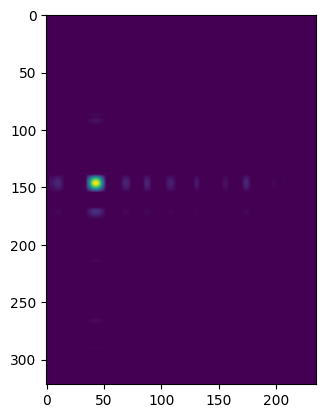

In [29]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## OpenCV可视化

In [30]:
img_bgr = cv2.imread(img_path)

In [48]:
# 检测框的颜色
bbox_color = (150,0,0)
# 检测框的线宽
bbox_thickness = 2
# 关键点半径
kpt_radius = 1
# 连接线宽
skeleton_thickness = 3

In [49]:
# 三角板关键点检测数据集-元数据（直接从config配置文件中粘贴）
dataset_info = {
    'keypoint_info':{
        0:{'name': 'face_0', 'id': 0, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        1:{'name': 'face_1', 'id': 1, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        2:{'name': 'face_2', 'id': 2, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        3:{'name': 'face_3', 'id': 3, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        4:{'name': 'face_4', 'id': 4, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        5:{'name': 'face_5', 'id': 5, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        6:{'name': 'face_6', 'id': 6, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        7:{'name': 'face_7', 'id': 7, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        8:{'name': 'face_8', 'id': 8, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        9:{'name': 'face_9', 'id': 9, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        10:{'name': 'face_10', 'id': 10, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        11:{'name': 'face_11', 'id': 11, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        12:{'name': 'face_12', 'id': 12, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        13:{'name': 'face_13', 'id': 13, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        14:{'name': 'face_14', 'id': 14, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        15:{'name': 'face_15', 'id': 15, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        16:{'name': 'face_16', 'id': 16, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        17:{'name': 'face_17', 'id': 17, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        18:{'name': 'face_18', 'id': 18, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        19:{'name': 'face_19', 'id': 19, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        20:{'name': 'face_20', 'id': 20, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        21:{'name': 'face_21', 'id': 21, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        22:{'name': 'face_22', 'id': 22, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        23:{'name': 'face_23', 'id': 23, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        24:{'name': 'face_24', 'id': 24, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        25:{'name': 'face_25', 'id': 25, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        26:{'name': 'face_26', 'id': 26, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        27:{'name': 'face_27', 'id': 27, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        28:{'name': 'face_28', 'id': 28, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        29:{'name': 'face_29', 'id': 29, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        30:{'name': 'face_30', 'id': 30, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        31:{'name': 'face_31', 'id': 31, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        32:{'name': 'face_32', 'id': 32, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        33:{'name': 'face_33', 'id': 33, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        34:{'name': 'face_34', 'id': 34, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        35:{'name': 'face_35', 'id': 35, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        36:{'name': 'face_36', 'id': 36, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        37:{'name': 'face_37', 'id': 37, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        38:{'name': 'face_38', 'id': 38, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        39:{'name': 'face_39', 'id': 39, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        40:{'name': 'face_40', 'id': 40, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        41:{'name': 'face_41', 'id': 41, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        42:{'name': 'face_42', 'id': 42, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        43:{'name': 'face_43', 'id': 43, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        44:{'name': 'face_44', 'id': 44, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        45:{'name': 'face_45', 'id': 45, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        46:{'name': 'face_46', 'id': 46, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        47:{'name': 'face_47', 'id': 47, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        48:{'name': 'face_48', 'id': 48, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        49:{'name': 'face_49', 'id': 49, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        50:{'name': 'face_50', 'id': 50, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        51:{'name': 'face_51', 'id': 51, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        52:{'name': 'face_52', 'id': 52, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        53:{'name': 'face_53', 'id': 53, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        54:{'name': 'face_54', 'id': 54, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        55:{'name': 'face_55', 'id': 55, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        56:{'name': 'face_56', 'id': 56, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        57:{'name': 'face_57', 'id': 57, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        58:{'name': 'face_58', 'id': 58, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        59:{'name': 'face_59', 'id': 59, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        60:{'name': 'face_60', 'id': 60, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        61:{'name': 'face_61', 'id': 61, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        62:{'name': 'face_62', 'id': 62, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        63:{'name': 'face_63', 'id': 63, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        64:{'name': 'face_64', 'id': 64, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        65:{'name': 'face_65', 'id': 65, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        66:{'name': 'face_66', 'id': 66, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        67:{'name': 'face_67', 'id': 67, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        68:{'name': 'face_68', 'id': 68, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        69:{'name': 'face_69', 'id': 69, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        70:{'name': 'face_70', 'id': 70, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        71:{'name': 'face_71', 'id': 71, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        72:{'name': 'face_72', 'id': 72, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        73:{'name': 'face_73', 'id': 73, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        74:{'name': 'face_74', 'id': 74, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        75:{'name': 'face_75', 'id': 75, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        76:{'name': 'face_76', 'id': 76, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        77:{'name': 'face_77', 'id': 77, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        78:{'name': 'face_78', 'id': 78, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        79:{'name': 'face_79', 'id': 79, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        80:{'name': 'face_80', 'id': 80, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        81:{'name': 'face_81', 'id': 81, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        82:{'name': 'face_82', 'id': 82, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        83:{'name': 'face_83', 'id': 83, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        84:{'name': 'face_84', 'id': 84, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        85:{'name': 'face_85', 'id': 85, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        86:{'name': 'face_86', 'id': 86, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        87:{'name': 'face_87', 'id': 87, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        88:{'name': 'face_88', 'id': 88, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        89:{'name': 'face_89', 'id': 89, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        90:{'name': 'face_90', 'id': 90, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        91:{'name': 'face_91', 'id': 91, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        92:{'name': 'face_92', 'id': 92, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        93:{'name': 'face_93', 'id': 93, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        94:{'name': 'face_94', 'id': 94, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        95:{'name': 'face_95', 'id': 95, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        96:{'name': 'face_96', 'id': 96, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        97:{'name': 'face_97', 'id': 97, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        98:{'name': 'face_98', 'id': 98, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        99:{'name': 'face_99', 'id': 99, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        100:{'name': 'face_100', 'id': 100, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        101:{'name': 'face_101', 'id': 101, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        102:{'name': 'face_102', 'id': 102, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        103:{'name': 'face_103', 'id': 103, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        104:{'name': 'face_104', 'id': 104, 'color': [255, 0, 0], 'type': '', 'swap': ''},
        105:{'name': 'face_105', 'id': 105, 'color': [255, 0, 0], 'type': '', 'swap': ''}
    },
    'skeleton_info': {
        0: {'link':('face_1','face_2'),'id': 0,'color': [100,150,200]},
        1: {'link':('face_2','face_3'),'id': 1,'color': [200,100,150]},
        2: {'link':('face_3','face_4'),'id': 2,'color': [150,120,100]}
    }
}

In [50]:
# 关键点类别和关键点ID的映射字典
label2id = {}
for each in dataset_info['keypoint_info'].items():
    label2id[each[1]['name']] = each[0]

In [51]:
for bbox_idx, bbox in enumerate(bboxes): # 遍历每个检测框

    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_color, bbox_thickness)
    
    # 索引为 0 的框，每个关键点的坐标
    keypoints = data_samples.pred_instances.keypoints[bbox_idx,:,:].astype('int')

    # 画连线
    for skeleton_id, skeleton in dataset_info['skeleton_info'].items(): # 遍历每一种连接
        skeleton_color = skeleton['color']
        srt_kpt_id = label2id[skeleton['link'][0]] # 起始点的类别 ID
        srt_kpt_xy = keypoints[srt_kpt_id]         # 起始点的 XY 坐标
        dst_kpt_id = label2id[skeleton['link'][1]] # 终止点的类别 ID
        dst_kpt_xy = keypoints[dst_kpt_id]         # 终止点的 XY 坐标
        img_bgr = cv2.line(img_bgr, (srt_kpt_xy[0],srt_kpt_xy[1]),(dst_kpt_xy[0],dst_kpt_xy[1]),color=skeleton_color,thickness=skeleton_thickness)
    
    # 画关键点
    for kpt_idx, kpt_xy in enumerate(keypoints): # 遍历该检测框中的每一个关键点
        kpt_color = dataset_info['keypoint_info'][kpt_idx]['color']
        img_bgr = cv2.circle(img_bgr, (kpt_xy[0], kpt_xy[1]), kpt_radius, kpt_color, -1)

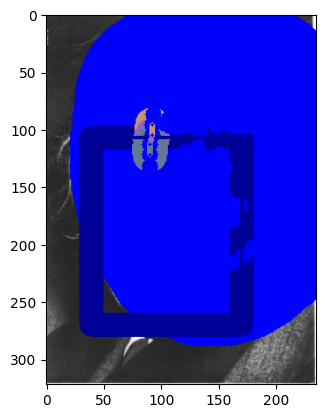

In [52]:
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [37]:
cv2.imwrite('outputs/G3_opencv.jpg', img_bgr)

True

## MMPose官方可视化工具`visualizer`

In [32]:
# 半径
pose_estimator.cfg.visualizer.radius = 50
# 线宽
pose_estimator.cfg.visualizer.line_width = 20
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

D:\Anaconda3\envs\openmmlab\lib\site-packages\mmengine\visualization\visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [33]:
# 元数据
# pose_estimator.dataset_meta

In [34]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show=False,
            show_kpt_idx=True,
            wait_time=0,
            out_file='outputs/G3_visualizer.jpg',
            kpt_thr=0.3
)

In [35]:
img_output.shape

(644, 235, 3)

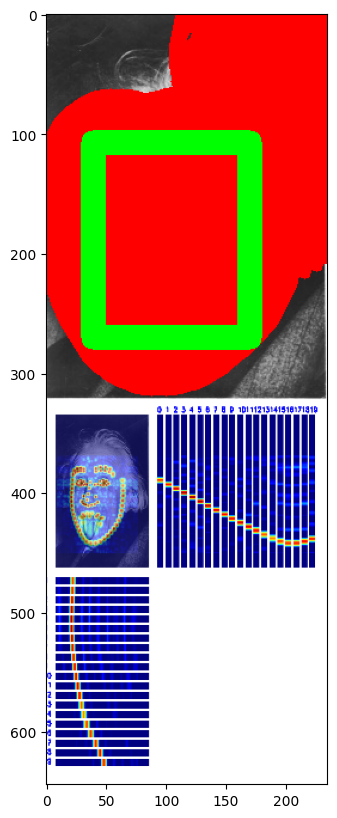

In [36]:
plt.figure(figsize=(10, 10))
plt.imshow(img_output)
plt.show()